In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [3]:
import Foundation
import Just
import Path

In [4]:
public func FacesDataBunch(path: Path = mnistPath, bs: Int = 20)
   -> DataBunch<DataBatch<TF, TI>> {
    let tr_x = np.load((path/"trainX.npy").string).astype(np.float32) / 255.0
    let tr_y = np.load((path/"trainY.npy").string).astype(np.int32)
    let ts_x = np.load((path/"testX.npy").string).astype(np.float32) / 255.0
    let ts_y = np.load((path/"testY.npy").string).astype(np.int32)
    let xTrain = Tensor<Float>(ShapedArray<Float>(numpy: tr_x)!)
    let yTrain = Tensor<Int32>(ShapedArray<Int32>(numpy: tr_y)!)
    let xValid = Tensor<Float>(ShapedArray<Float>(numpy: ts_x)!)
    let yValid = Tensor<Int32>(ShapedArray<Int32>(numpy: ts_y)!)
    return DataBunch(train: Dataset(elements: DataBatch(xb:xTrain, yb: yTrain)), 
                     valid: Dataset(elements: DataBatch(xb:xValid, yb: yValid)),
                     trainLen: xTrain.shape[0],
                     validLen: xValid.shape[0],
                     bs: bs)
}


In [5]:
let d = FacesDataBunch(path: Path.home/"swift",bs: 40)

In [6]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [40, 10304]
  ▿ dimensions : 2 elements
    - 0 : 40
    - 1 : 10304


In [7]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid1: Int, nHid2: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid1, activation: relu)
        hidden2 = FADense(nHid1, nHid2, activation: relu)
        out =     FADense(nHid2, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [8]:
func modelInit() -> MyModel { return MyModel(nIn: 10304, nHid1: 2048,nHid2: 512, nOut: 20) }

In [9]:
public let FacesStats = (mean: TF(0.4617096), std: TF(0.20259255))

In [10]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [11]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [13]:
func optFunc(_ model: MyModel) -> SGD<MyModel> { return SGD(for: model, learningRate: 0.01)}

let learner = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_sgd = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [14]:
learner.fit(25)

Epoch 0: Train: [2.5838068, 0.29583332] , Valid:[1.9012158, 0.65]          
Epoch 1: Train: [1.3325138, 0.81666666] , Valid:[1.2858541, 0.7625]       
Epoch 2: Train: [0.6987869, 0.9791667] , Valid:[0.91637504, 0.88125]      
Epoch 3: Train: [0.39250886, 1.0] , Valid:[0.72493255, 0.925]             
Epoch 4: Train: [0.2592739, 0.99583334] , Valid:[0.62965214, 0.91875]     
Epoch 5: Train: [0.18748194, 1.0] , Valid:[0.5403391, 0.9375]             
Epoch 6: Train: [0.14143947, 1.0] , Valid:[0.49203214, 0.93125]           
Epoch 7: Train: [0.11251501, 1.0] , Valid:[0.46151638, 0.9375]            
Epoch 8: Train: [0.09381238, 1.0] , Valid:[0.4335944, 0.94375]            
Epoch 9: Train: [0.08042364, 1.0] , Valid:[0.4118951, 0.94375]            
Epoch 10: Train: [0.06843274, 1.0] , Valid:[0.39441505, 0.94375]          
Epoch 11: Train: [0.060838077, 1.0] , Valid:[0.3830426, 0.94375]          
Epoch 12: Train: [0.05358955, 1.0] , Valid:[0.36788565, 0.94375]          
Epoch 13: Train: [0.0482

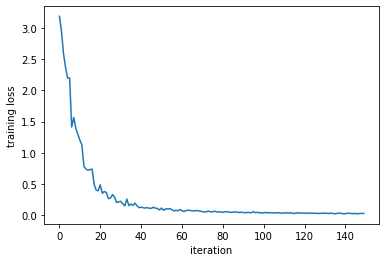

In [15]:
recorder_sgd.plotLosses()

# MLP 2 with  Nesterov

In [17]:
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}
let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner_nest.addDelegates([learner_nest.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [18]:
try! learner_nest.fit(25)

Epoch 0: Train: [2.5493727, 0.325] , Valid:[1.8042599, 0.7125]            
Epoch 1: Train: [1.2893096, 0.875] , Valid:[1.2002156, 0.8375]            
Epoch 2: Train: [0.64491934, 0.98333335] , Valid:[0.89178735, 0.8875]     
Epoch 3: Train: [0.38775834, 1.0] , Valid:[0.7233454, 0.9125]             
Epoch 4: Train: [0.26633337, 1.0] , Valid:[0.60651076, 0.90625]           
Epoch 5: Train: [0.18514095, 1.0] , Valid:[0.53753674, 0.925]             
Epoch 6: Train: [0.1434852, 1.0] , Valid:[0.48802176, 0.925]              
Epoch 7: Train: [0.11379897, 1.0] , Valid:[0.45608854, 0.91875]           
Epoch 8: Train: [0.094035715, 1.0] , Valid:[0.41968137, 0.925]            
Epoch 9: Train: [0.08067975, 1.0] , Valid:[0.39733392, 0.925]             
Epoch 10: Train: [0.069007084, 1.0] , Valid:[0.3830934, 0.925]            
Epoch 11: Train: [0.060429323, 1.0] , Valid:[0.36641926, 0.93125]         
Epoch 12: Train: [0.054725718, 1.0] , Valid:[0.3553623, 0.91875]          
Epoch 13: Train: [0.04879

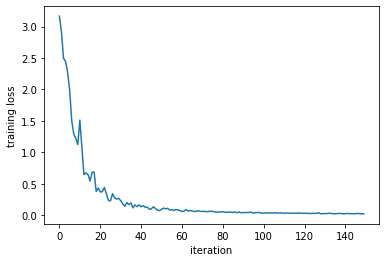

In [19]:
recorder_nest.plotLosses()

# MLP 3 with Nesterov and L1

In [20]:
//Optimizer with Nesterov step and L1 regularizer
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [21]:
learner_nest_l1.fit(25)

Epoch 0: Train: [2.6373508, 0.2125] , Valid:[2.0120592, 0.55625]          
Epoch 1: Train: [1.4081154, 0.85833335] , Valid:[1.3368566, 0.775]        
Epoch 2: Train: [0.75149, 0.97083336] , Valid:[0.9474171, 0.875]          
Epoch 3: Train: [0.43268913, 1.0] , Valid:[0.7349547, 0.9375]             
Epoch 4: Train: [0.27646, 1.0] , Valid:[0.6058482, 0.9375]                
Epoch 5: Train: [0.19732353, 1.0] , Valid:[0.5180882, 0.95625]            
Epoch 6: Train: [0.14832345, 1.0] , Valid:[0.46144992, 0.94375]           
Epoch 7: Train: [0.118498735, 1.0] , Valid:[0.42453256, 0.95]             
Epoch 8: Train: [0.09829675, 1.0] , Valid:[0.39662853, 0.94375]           
Epoch 9: Train: [0.08245428, 1.0] , Valid:[0.3750022, 0.95]               
Epoch 10: Train: [0.07134639, 1.0] , Valid:[0.3549559, 0.95]              
Epoch 11: Train: [0.061645333, 1.0] , Valid:[0.33822903, 0.95]            
Epoch 12: Train: [0.05513154, 1.0] , Valid:[0.32354638, 0.95]             
Epoch 13: Train: [0.04923

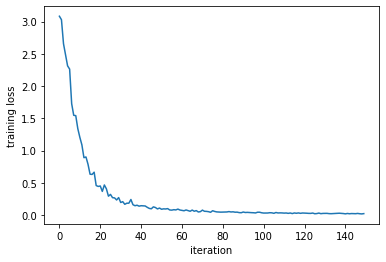

In [22]:
recorder_nest_l1.plotLosses()

# MLP 4 with Nesterov and L2

In [23]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L2()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [24]:
learner_nest_l2.fit(25)

Epoch 0: Train: [2.3512118, 0.325] , Valid:[1.2073094, 0.6375]              
Epoch 1: Train: [0.5127129, 0.89166665] , Valid:[0.85374606, 0.725]        
Epoch 2: Train: [0.20965426, 0.93333334] , Valid:[0.56818265, 0.85625]     
Epoch 3: Train: [0.057050336, 0.9875] , Valid:[0.5527979, 0.89375]          
Epoch 4: Train: [0.028044295, 0.9916667] , Valid:[0.44371334, 0.9125]       
Epoch 5: Train: [0.00590916, 1.0] , Valid:[0.5507606, 0.90625]             
Epoch 6: Train: [0.0030862575, 1.0] , Valid:[0.46696776, 0.93125]           
Epoch 7: Train: [0.0015379136, 1.0] , Valid:[0.40251312, 0.93125]           
Epoch 8: Train: [0.0009856961, 1.0] , Valid:[0.3573996, 0.9375]            
Epoch 9: Train: [0.00067592255, 1.0] , Valid:[0.33967423, 0.93125]          
Epoch 10: Train: [0.0004604147, 1.0] , Valid:[0.33147636, 0.9375]           
Epoch 11: Train: [0.00039505406, 1.0] , Valid:[0.32742777, 0.9375]         
Epoch 12: Train: [0.00035602725, 1.0] , Valid:[0.32517782, 0.95]           
Epoch

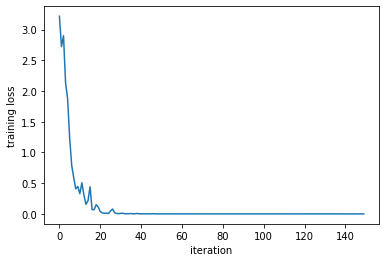

In [25]:
recorder_nest_l2.plotLosses()

In [26]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [27]:
func smooth_curve(points:Array<Float>, factor:Float=0.99) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

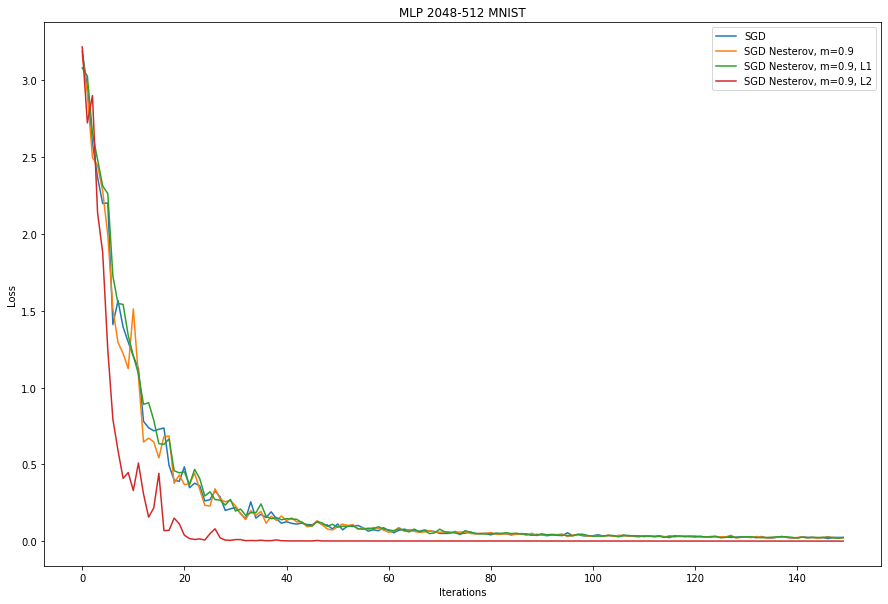

None


In [28]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 150
let y2 = Array(y[i..<n])
plt.plot(y2,Array(sgd[i..<n]), label:"SGD")
plt.plot(y2,Array(nest[i..<n]), label:"SGD Nesterov, m=0.9")
plt.plot(y2,Array(nest_l1[i..<n]), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,Array(nest_l2[i..<n]), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 2048-512 MNIST")
plt.show()